This notebook aims to perform Bengali digit recognition using Convolutional Neural Network algorithm. The model is trained from scratch on a publicly available dataset known as NumtaDB and tested on an inference set unseen during the training phase by the model. The architecture of the network and hyperparameters of the model are chosen through the trial-and-error method by observing the bias (underfit) and variance (overfit) tradeoff plotted in the 'Loss vs Epoch' graph during the training process. Percentage of the samples in the test set correctly recognized by the model, known as test accuracy, is used as the evaluation metric, which turns out to be about 88.9% in this experiment. A confusion matrix is plotted to show the prediction accuracy for each type of digit.

In [1]:
# Import the standard library and packages.

import pickle, gzip
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import math

In [2]:
# Import the necessary python scripts

from ConvolutionalNeuralNetwork import ConvolutionalNeuralNetwork
from Standardization import Standardization
from NumtaDigitDataset import NumtaDigitDataset
from CollateFunction import collate_fn
import DataProcessing as DP
import CNNModelAnalysis as CMA

In [3]:
# Assign the data path

home = os.path.expanduser('~')
train_dir = home + '/Desktop/DataDir/NumtaDB/Training'
#train_info_path = home + '/Desktop/DataDir/NumtaDB/training-a.csv'
test_dir = home + '/Desktop/DataDir/NumtaDB/Testing' #/testing-a'

In [4]:
# Read the data

dfs = []
for csvf in glob.iglob(train_dir + '/*.csv'):
    df = pandas.read_csv(csvf)
    df['filename'] = df['filename'].apply(lambda x: csvf.split('/')[-1].split('.')[0] + '/' + x)
    dfs.append(df)
train_df = pandas.concat(dfs, ignore_index=True)
train_df.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,training-c/c00000.png,Scan_280_digit_6_num_7.png,280,6,OngkoDB,Buet_Backpropers,training-c
1,training-c/c00001.png,Scan_29_digit_1_num_1.png,29,1,OngkoDB,Buet_Backpropers,training-c
2,training-c/c00002.png,Scan_131_digit_3_num_1.png,131,3,OngkoDB,Buet_Backpropers,training-c
3,training-c/c00003.png,Scan_160_digit_2_num_2.png,160,2,OngkoDB,Buet_Backpropers,training-c
4,training-c/c00004.png,Scan_202_digit_7_num_0.png,202,7,OngkoDB,Buet_Backpropers,training-c


In [12]:
# Create numpy arrays of the input data (X) and target class (Y)

X, T = train_df['filename'].to_numpy(), train_df['digit'].to_numpy()
X.shape, T.shape

((44000,), (44000,))

In [13]:
# Prepare train, validation, test dataset and load those into respective dataloaders. 
# Calculate the standardization parameters.

use_gpu = True

n_test = int(0.1 * len(X))

Xtest, Ttest = X[:n_test, ...], T[:n_test, ...] 
train_set, valid_set = DP.split_data(X[n_test:, ...], T[n_test:, ...])
Xtrain, Ttrain = train_set
Xvalid, Tvalid = valid_set


invalid_samples = [fpath for fpath in Xtrain if np.array(Image.open(train_dir + '/' + fpath)).ndim<2]
Xtrain_imgs = np.array([DP.to_gray(DP.resize(train_dir + '/' + fpath)).transpose(2, 0, 1) for fpath in Xtrain if fpath not in invalid_samples])
st_obj = Standardization(Xtrain_imgs)

img_channel = Xtrain_imgs.shape[1]

split_tuples_list = [(Xtrain, Ttrain), (Xvalid, Tvalid), (Xtest, Ttest)]

dataset_list = [NumtaDigitDataset(train_dir, stup, st_obj, invalid_samples) for stup in split_tuples_list]

batch_size_list = [512, 512, 512] if use_gpu else [32, 32, 32] #[100, 100, 100]
shuffle_list = [True, False, False]

trainloader, validloader, testloader = (torch.utils.data.DataLoader(dataset, 
                                                                    batch_size = batch_size, 
                                                                    collate_fn = collate_fn, 
                                                                    shuffle = shuffle) 
                                        for dataset, batch_size, shuffle 
                                        in zip(dataset_list, batch_size_list, shuffle_list))

In [14]:
# Number of samples that do not have a dimension of 3 after preprocessing.
len(invalid_samples)

0

In [15]:
# Number of samples in train, validation, and test set
Xtrain.shape, Xvalid.shape, Xtest.shape

((31680,), (7920,), (4400,))

In [9]:
# Define all parameters required for the model and for saving the results of the initial experiments.
# Run the experiments and save the best performing model's states.

preds_list = []
confs_list = []
evaluation_res_list = []

train_error_list = []
train_error_trace_list = []

valid_error_list = []
valid_error_trace_list = []

width = Xtrain_imgs.shape[2]
height = Xtrain_imgs.shape[3]
in_channels = Xtrain_imgs.shape[1] 
classes = np.unique(Ttrain)
use_gpu = True
dropout = 0.2
bnorm = False #True

# (n_units_in_conv_layers[...], kernel_size_and_stride[[],[],...], n_units_in_fc_layers[...])
arch_list = [([], [], [None, None], []), 
             ([], [], [None, None], [10]), 
             ([5, 10], [[3, 3, 0], [3, 3, 0]], [None, None], []), 
             ([2, 3], [[3, 3, 0], [2, 2, 0]], [None, None], [3]), 
             ([5, 4], [[3, 3, 0], [2, 2, 0]], [None, None], []), 
             ([10, 20], [[3, 3, 0], [2, 2, 0]], [None, None], []), 
             ([1, 2], [[3, 3, 0], [2, 2, 0]], [None, None], [])]

lr_list = [0.01, 0.001, 0.005, 0.02, 0.03, 0.01, 0.01]
n_epochs_list = [20, 20, 20, 20, 20, 20, 20] #[20, 10, 10, 20]

best_vloss = None
states_path = './saved_states/numta_model_states.pth'

for arch, learning_rate, n_epochs in zip(arch_list, lr_list, n_epochs_list):

    print('|', end=' ')
    
    n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers = arch

    conv_model = ConvolutionalNeuralNetwork(in_channels, width, height, 
                                          n_units_in_conv_layers, kernel_size_and_stride_padding, 
                                            maxpool_kernel_stride_padding, n_units_in_fc_layers, 
                                          classes, use_gpu)
    
    conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss = best_vloss, states_path = states_path)
    best_vloss = conv_model.get_best_validation_loss()
    
    train_error_trace, valid_error_trace = conv_model.get_error_trace()
    train_error = train_error_trace[-1]
    valid_error = valid_error_trace[-1]
    train_error_trace_list.append(train_error_trace)
    train_error_list.append(train_error)
    valid_error_trace_list.append(valid_error_trace)
    valid_error_list.append(valid_error)
    
    Y_preds, Y_confs = conv_model.predict(testloader) #trainloader
    confs_list.append(Y_confs)
    preds_list.append(Y_preds)
    evaluation_res_list.append(conv_model.evaluate(testloader))

| | | | | | | 

In [10]:
# Show the initial results of the experiments.

pandas.set_option('display.max_colwidth', None)
pandas.DataFrame([arch_list, n_epochs_list, lr_list, train_error_list, valid_error_list, evaluation_res_list], 
                 index = ['Model Arch', 'Epochs', 'lr', 'Tr-loss', 'Val-loss', 'Test Acc']).T

,Model Arch,Epochs,lr,Tr-loss,Val-loss,Test Acc
0,"([], [], [None, None], [])",20,0.01,0.864196,2.830121,0.408
1,"([], [], [None, None], [10])",20,0.001,1.624044,1.839212,0.388
2,"([5, 10], [[3, 3, 0], [3, 3, 0]], [None, None], [])",20,0.005,1.495176,1.621551,0.452
3,"([2, 3], [[3, 3, 0], [2, 2, 0]], [None, None], [3])",20,0.02,1.864571,1.937688,0.28
4,"([5, 4], [[3, 3, 0], [2, 2, 0]], [None, None], [])",20,0.03,1.305015,1.55259,0.528
5,"([10, 20], [[3, 3, 0], [2, 2, 0]], [None, None], [])",20,0.01,0.417676,1.545391,0.676
6,"([1, 2], [[3, 3, 0], [2, 2, 0]], [None, None], [])",20,0.01,1.725457,1.796208,0.378


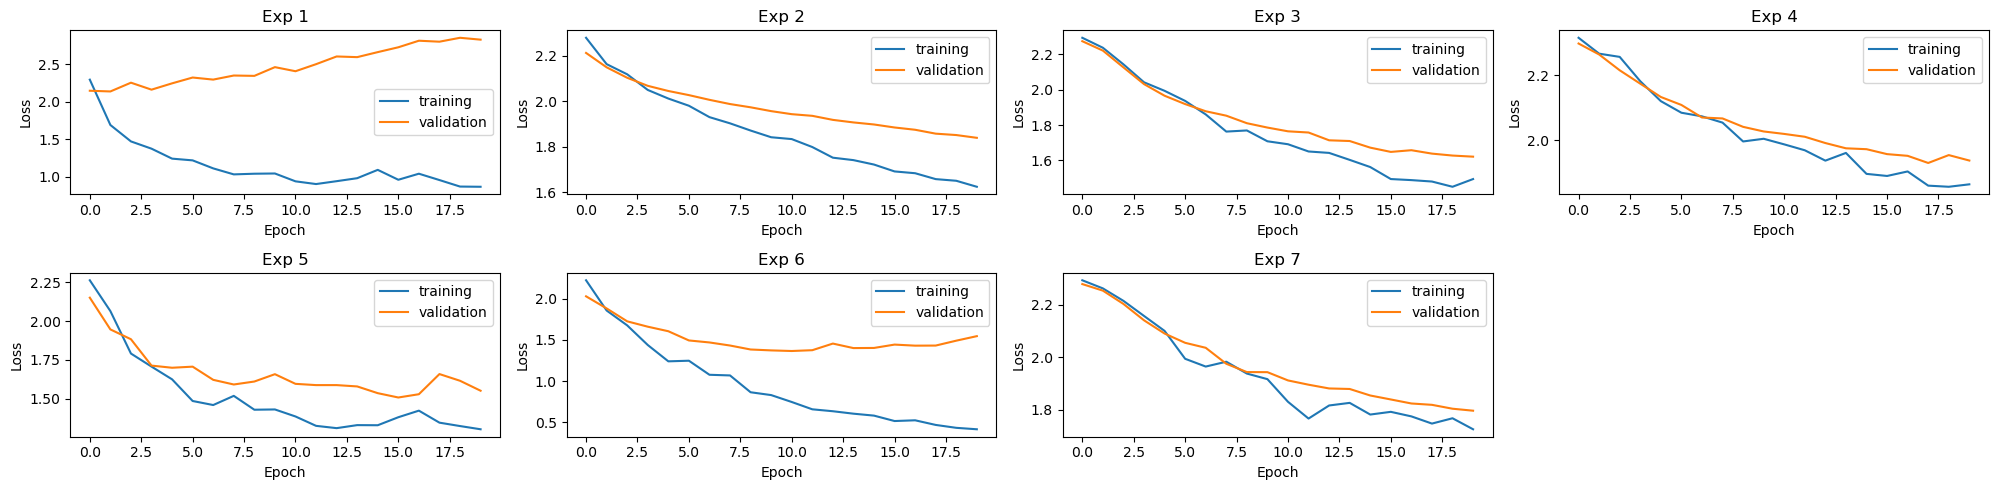

In [11]:
# The loss plots of the experiments.

plt.figure(figsize = (20, 5))
n = len(arch_list)
col = 4 #int(n/4)
row = math.ceil(n/col)
for i in range(n):
    plt.subplot(row, col, i+1)
    plt.plot(train_error_trace_list[i], label = 'training')
    plt.plot(valid_error_trace_list[i], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Exp {i+1}')
plt.tight_layout()

In [16]:
# Choose the network with better result, change anything needed, and train longer.

states_path = './saved_states/numta_model_states.pth'

checkpoint = torch.load(states_path)
#best_idx = np.argmax(evaluation_res_list)
best_args = checkpoint['model_args']
n_epochs = checkpoint['epoch']
learning_rate = checkpoint['loss']

in_channels, width, height, n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers, classes, use_gpu, dropout, bnorm = best_args

# Change if you need to -
n_units_in_conv_layers = [64, 128]
kernel_size_and_stride = [[3, 3, 0], [2, 2, 0]]
#maxpool_kernel_stride_padding = [[2, 1, 0], [2, 1, 0], [2, 1, 0]] 
n_units_in_fc_layers = []

learning_rate = 0.0008
n_epochs = 30
dropout = None #0.2
bnorm = True

# Specify a new path for saving the states of this trial.
best_vloss = None
states_path = './saved_states/numta_model_states_trial.pth'

conv_model = ConvolutionalNeuralNetwork(in_channels, width, height, 
                                      n_units_in_conv_layers, kernel_size_and_stride_padding, 
                                        maxpool_kernel_stride_padding, n_units_in_fc_layers, 
                                      classes, use_gpu, dropout, bnorm)

# Now either load the trained model's states and retrain (uncomment the following line)
#conv_model.nnet.load_state_dict(checkpoint['model_state_dict'])
# Or, train from scratch

conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss = best_vloss, states_path = states_path)
best_vloss = conv_model.get_best_validation_loss()
print(f'Best validation loss: {best_vloss:.3f}')

train_error_trace, valid_error_trace = conv_model.get_error_trace()

Y_preds, Y_confs = conv_model.predict(testloader)
Test_acc = conv_model.evaluate(testloader)
print(f'Test Accuracy: {Test_acc:.3f}')

Best validation loss: 0.180
Test Accuracy: 0.889


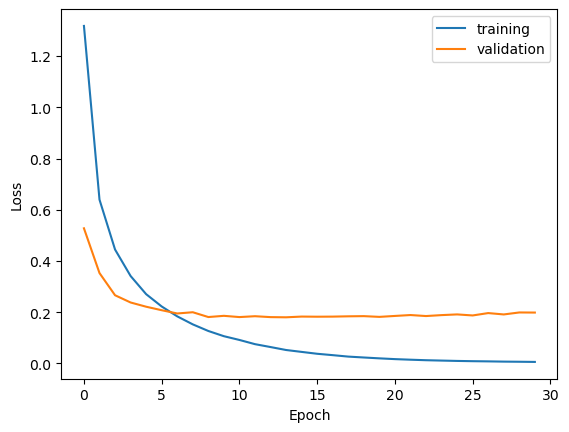

In [17]:
# Try dropout (regularization since overfitting)

plt.plot(train_error_trace, label = 'training')
plt.plot(valid_error_trace, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

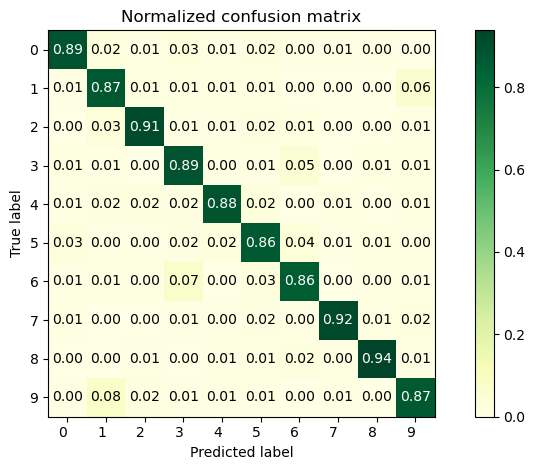

In [18]:
# Add confusion matrix on test set

Pte, Prte = conv_model.predict(testloader) #nnet.use(Xtenn)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
CMA.plot_confusion_matrix(Ttest, Pte, classes=np.unique(Ttest).astype(int),
                      title='Normalized confusion matrix')

plt.show()

In [19]:
# Use the preferred trained model to test on a different set of samples (rerun the dataloader cell to get a different set).
# Use either './saved_states/numta_model_states.pth' or './saved_states/numta_model_states_trial.pth'

reuse_states_path = './saved_states/numta_model_states_trial.pth'
checkpoint = torch.load(reuse_states_path) #('numta_model_states.pth')

conv_model_resume = ConvolutionalNeuralNetwork(*checkpoint['model_args'])

conv_model_resume.nnet.load_state_dict(checkpoint['model_state_dict'])
Y_pred, Y_conf = conv_model_resume.predict(testloader) 
eval_result = conv_model_resume.evaluate(testloader)
print(f'{eval_result:.4f}')

0.8861


## Inference on unseen and unlabeled set

In [20]:
# List of images' paths for inference

inferset = ['/'.join(fname.split('/')[-2:]) for fname in glob.iglob(test_dir + '/**/*.png', recursive = True)]

In [21]:
# Prepare the dataset and dataloader for inference.

inferdataset = NumtaDigitDataset(test_dir, inferset, st_obj)
inferloader = torch.utils.data.DataLoader(inferdataset, batch_size = len(inferset), collate_fn = collate_fn, shuffle = False)                           

In [22]:
# Predict the class of the inference set using the trained model.

infer_Y_pred, infer_Y_conf = conv_model_resume.predict(inferloader)

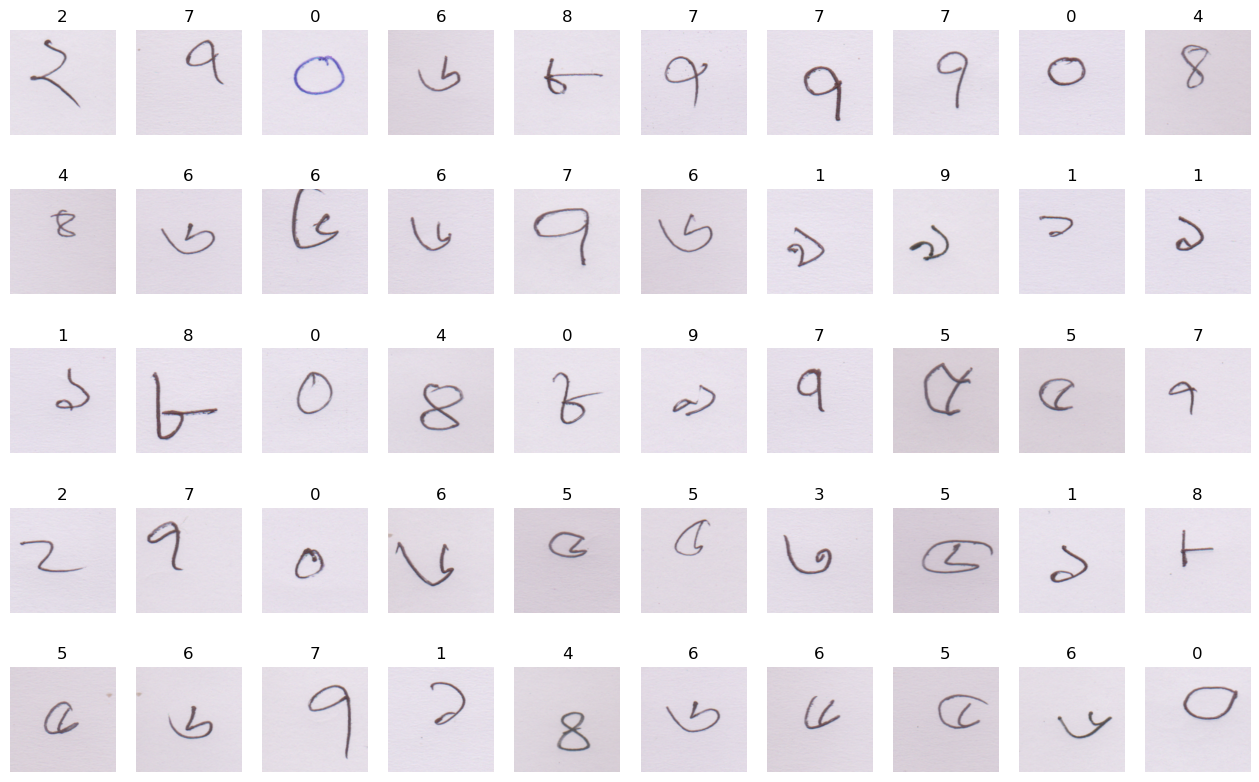

In [23]:
# Inspect visually the images and their prediction (on top of each image) by the model.

plt.figure(figsize = (16, 10))
row = 5
col = 10
total = int(row * col)
rand_ind = np.random.randint(0, len(inferset), total)
for i in range(total):
    plt.subplot(row, col, i+1)
    img = plt.imread(test_dir + '/' + inferset[rand_ind[i]])
    plt.imshow(img)
    plt.title(label = infer_Y_pred[rand_ind[i]])
    plt.axis('off');

## Reference & Acknowledgement

1. https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
2. https://www.kaggle.com/datasets/BengaliAI/numta/code
3. [Ignore bad samples in getitem of dataset](https://stackoverflow.com/questions/57815001/pytorch-collate-fn-reject-sample-and-yield-another/67583699#67583699)